In this post we discuss a fundamental model in financial time series modelling - the ARCH model. 

The model was introduced by Engle in the 80's and brought him a Nobel prize in Economy. 
Nowadays ARCH is still the go-to model, or at least a starting point for time series with varying volatility, a characteristic 
shared by many financial return series.  

## ARCH model

The ARCH model is widely used to model financial return time series.
In this post, we always denote a time series by $(Y_t)$.
ARCH model is a specification of the conditional variance of $Y_t$ given its history $\mathcal F_{t-1}$
by the following equation: 
$$\mathrm{Var}[Y_t| \mathcal F_{t-1}] = \omega + \alpha Y_{t-1}^2.$$

In code, it is straightforward to define the ARCH model with the `arch` library. 

## `arch` library

In [1]:
import numpy as np
from arch import arch_model

In [2]:
rng = np.random.default_rng(41)
y = rng.standard_normal(size=(500,)) * np.arange(500) * 0.2
mod = arch_model(y, mean='zero', q=0)
res = mod.fit(disp="off")
fcst = res.forecast(horizon=50, method="bootstrap", simulations=3)

Above  we exposed the main classes of the library.      
- `arch_model` is a convenience model constructor function with which one can specify the the mean process, the volatility (aka conditional standard deviation), the noise distribution (adhere to `scipy.stats`).  
- `mod.fit()` returns a result container: one that contains residuals, standardised residuals, conditional volatility of the fit model.    
- `res.forecast()` returns a forecast container: one that contains conditonal variance given the present value, simulations given the current value  etc.   

In [3]:
type(mod), type(res), type(fcst)

(arch.univariate.mean.ZeroMean,
 arch.univariate.base.ARCHModelResult,
 arch.univariate.base.ARCHModelForecast)

In [4]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:               -2719.79
Distribution:                  Normal   AIC:                           5443.58
Method:            Maximum Likelihood   BIC:                           5452.01
                                        No. Observations:                  500
Date:                Tue, Oct 15 2024   Df Residuals:                      500
Time:                        20:37:19   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega       2082.8286    396.923      5.247  1.542e-07 [1.305e+03,2.861e+03]
alpha[1]       0.4962      0.174      2.850  4.377e-03     [  0.155,  0.838]
============================================================================

Covariance estimator: robust
"""

:NdOverlay   [Variable]
   :Curve   [index]   (value)
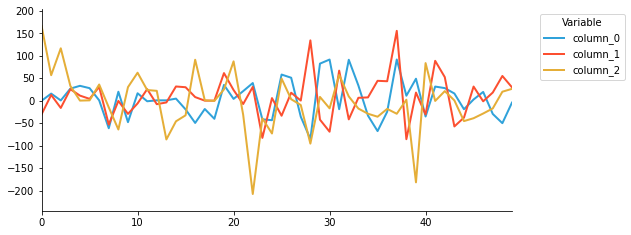

In [5]:
import polars as pl
import hvplot.polars
hvplot.extension('matplotlib')

pl.DataFrame(fcst.simulations.values.squeeze().T).hvplot() # 3 forecasted paths with horizon 50

<!-- ## Zooming in: the result summary

There are plenty of information in the summary. Most of them should be self-explanatory if one is familiar with basic terminology of statistical inference. Notice that the model we defind is `GARCH`, where "G" stands for "Generalised". A typical GARCH process is GARCH(1,1) defined through the specification: 
$$\mathrm{Var}[Y_t| \mathcal F_{t-1}] = \omega + \alpha Y_{t-1}^2 + \beta \mathrm{Var}[Y_{t-1}| \mathcal F_{t-2}].$$ -->


## Mean model and noise distribution

By default the noise distribution is standard normal. 
Another popular choice is t distribution where the degree of freedom $\nu$ is a model parameter.    
One can also change the mean to be non-zero. The model spec is as follows 
$$
\begin{align*}
Y_t &= \mu + \sigma_t W_t \\  
\sigma_t^2 &= \omega+ \alpha (Y_{t-1}-\mu)^2
\end{align*}
$$
where $W_t$ is iid with t distribution. 

In `arch`, it suffices to set `mean="constant"` and `dist="t"` in the constructor.  

In [6]:
arch_model(y=y+30, mean="constant", q=0, dist='t').fit(disp="off")

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -2679.58
Distribution:      Standardized Student's t   AIC:                           5367.17
Method:                  Maximum Likelihood   BIC:                           5384.03
                                              No. Observations:                  500
Date:                      Tue, Oct 15 2024   Df Residuals:                      499
Time:                              20:37:22   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            27

Why stop here? We can also allow the conditonal mean of $Y_t$ given history to vary with time as well, one simplest choice would be to 
assume AR dynamic for the conditional mean
$$
\begin{align*}
Y_t &= \mu + \phi (Y_{t-1} - \mu) + \sigma_t W_t \\  
\sigma_t^2 &= \omega+ \alpha (Y_{t-1}-\mu)^2
\end{align*}
$$
where as before $W_t$ is iid normal by default. 

In code, just set `mean="AR"` and `lags=[1]` where 1 is as in AR(1) for the conditional mean.  

In [7]:
arch_model(y=y+30, mean="AR", q=0, lags=[1]).fit(disp="off")

                           AR - ARCH Model Results                            
Dep. Variable:                      y   R-squared:                      -0.009
Mean Model:                        AR   Adj. R-squared:                 -0.011
Vol Model:                       ARCH   Log-Likelihood:               -2713.60
Distribution:                  Normal   AIC:                           5435.21
Method:            Maximum Likelihood   BIC:                           5452.06
                                        No. Observations:                  499
Date:                Tue, Oct 15 2024   Df Residuals:                      497
Time:                        20:37:22   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         27.0714      2.670     10.138  3.746e-24 [ 21.838, 32.30

as before, we can inspect the result container and forecast container as follows

In [8]:
res = arch_model(y+30, mean="AR", q=0, lags=[1]).fit(disp="off")
fcst = res.forecast(horizon=5)

notice the difference of `resid` and `std_resid`, as well as the diff between `variance` and `residual_variance`

In [9]:
res.resid[1:].std(), res.std_resid[1:].std()

(np.float64(58.66084093396231), np.float64(0.9985090629605182))

In [10]:
fcst.variance

,h.1,h.2,h.3,h.4,h.5
499,23353.942452,15527.507157,10965.954024,8317.077882,6778.893468


In [11]:
fcst.residual_variance

,h.1,h.2,h.3,h.4,h.5
499,23353.942452,15509.168033,10953.760756,8308.466659,6772.362326


## Generalized ARCH (GARCH)

Another generalization of the ARCH model focuses on the conditonal variance specification itself, rather than the conditional mean and the noise distribution. 
The most prominent example along this line of thinking is the GARCH family, which in its simplest form (zero mean model and lag 1) is specified as follows 
$$
\begin{align*}
Y_t &=  \sigma_t W_t \\
\sigma_{t}^2 &= \omega + \alpha Y_{t-1}^2 + \beta \sigma_{t-1}^2 
\end{align*}
$$
The difference lies in the additional beta parameter which specifies a dependence of the conditional variance on the conditional variance of previous timestamp.

GARCH generalizing ARCH is similar to the way ARMA generalizes AR. 


## Introducing `archette`

`archette` is a simplified implementation of the zero mean GARCH model with iid Gaussian noise. 

The existing `arch` library is amazing and covers many popular GARCH-type models. 
`archette` is not meant to replace `arch` in any way, after all, it supports only a very particular model (undoubtedly a very important one).

The goal of `archette` is to reduce the complexity of `arch` (e.g. all the class hierarchy) to highlight only the essence of GARCH model.
It is meant to be super hackable so that one can build variants of GARCH models by modifying parts of the source code of `archette`.

There is only one class `GARCHETTE` in `archette` which implements the methods:

- fit
- nll
- forecast_vs
- simulate

and the properties

- vs
- std_resids
- params

The API is simple. States are maintained in the instances of the main class rahter than delegated to separate container classes. 

Here is how one can fit a model and inspect the fitted parameters and the corresponding negative log likelihood. 

In [12]:
from archette import GARCHETTE

In [13]:
rng = np.random.default_rng()
y = rng.standard_normal(500) * np.arange(500)
mod = GARCHETTE()
mod.fit(y)

In [14]:
mod.params

array([1.81808314e+02, 1.78658879e-01, 8.21341121e-01])

In [15]:
mod.nll(mod.params)

np.float64(5844.282166604636)

#### Model fitting

The `fit` method calls under the hood the `minimize` function in `scipy.optimize` module to minimize the negative log likelihood (`nll`). 

Let $f$ denote the joint distribution of time series $y$. 
By successive conditioning, one can write the nll as
$$
-\log f(y) = - \log f_\theta(y_0) - \sum_{t=1}^{T} \log f_{\theta}(y_t | y_{[0,t-1]})
$$
where $y_{[0,t-1]}:= (y_0, ..., y_{t-1})$ and $\theta$ is the parameter.

Since the marginal distribution at time 0 is unknown, one typically remove the first term and minimize $-\log f(y|y_0)$ instead
$$
-\log f(y|y_0) = - \sum_{t=1}^{T} \log f_{\theta}(y_t | y_{[0,t-1]})
$$
By Gaussian noise assumption and lag 1, we have, up to some unimportant additive constant, 
$$
- \log f_{\theta}(y_t | y_{[0,t-1]}) = - \log f_{\theta}(y_t | y_{t-1}) = \frac{1}{2}\Big(\log v_t +  \frac{y_t^2}{v_t}\Big) 
$$
where $v_t$ is the conditional variance of $y_t$ given $y_{t-1}$ (which is denoted by $\sigma_t^2$ before). 

Notice that $v_0$ is not observable, hence one needs to set a sensible initial value, e.g. sample variance of $y$. 

We define two helper functions, one computes the sequence $v$, the other the nll. 

In [16]:
def _get_vs(y, params, sig2_init):
    """
    compute conditional variance by recursion of the GARCH specification
    """
    om,al,be = params
    vs = np.zeros(y.size)
    vs[0] = sig2_init
    for i in range(1,y.size):
        vs[i] = om + al * y[i-1]**2 + be * vs[i-1]
    return vs

In [17]:
def _nllgauss(y,params,sig2_init):
    """
    compute nll of GARCH(1,1) with zero conditional mean and gaussian noise
    """
    vs = _get_vs(y,params, sig2_init)
    nll =  np.log(vs) + y**2 / vs
    return nll.sum()

Now we are in a place to start writing the main class. 

In [18]:
from scipy.optimize import minimize

In [19]:
class GARCHETTE:
    """simple garch model"""
    def __init__(self):
        self._y = None
        self.params = None
        self._is_fit = False
        self._v_init = None

    def fit(self,y:np.ndarray):
        """fit y to garch"""
        self._y = y
        self._v_init = y.var()  
        self._is_fit = True
        func = self.nll
        self.params = minimize(
            func, 
            x0=(self._v_init * 0.4,0.3,0.3), 
            bounds=[(0,None), (0,None), (0,None)],
            constraints= {
                "type": "ineq",
                "fun": lambda x: 1-x[1]-x[2]
            }
         ).x
        return self
    
    def nll(self, params)-> float:
        """negative log likelihood of the series at the given params"""
        assert self._is_fit
        return _nllgauss(self._y, params, self._v_init)
    
    @property
    def vs(self):
        return _get_vs(self._y, self.params, self._v_init)

We see that the method `nll` and property `vs` are just wrappers around the helper functions that we just defined. 
The `fit` method, though, needs some attention. 
For the minimization of nll, apart from the objective function `nll` and initial value `x0`,
 it is also necessary to set bounds and constraints for the variables of `nll`. 
 We impose the parameters to be non-negative because the sequence `v` must be non-negative (as squares). 
 Also we need  
 $$
\alpha + \beta <1 
 $$ 
 because it is the necessary and sufficnet condition for the stationary of GARCH(1,1) model. 
 Having these constraints are essential for the optimization to work. 
 Finally, we made an educated guess for the initial value: we set the initial values $\alpha=\beta=0.3$ to leave some space to the boundary of 
 the constrained parameter space. 
 The initial value for $\omega$ is set based on an important fact about the long term conditional variance: for any $t$, as $T\to\infty$:
 $$
 \mathbb E[Y_{t+T}^2| \mathcal F_t] \to \frac{\omega}{1-\alpha-\beta} 
 $$
 If we believe that the sample variance of `y` approaches the long term conditonal variance, then initialize `om=(1-0.3-0.3)* y.var()` is indeed sensible. 

Now it remains to forecast variances (or equivalently the conditional volatility) and simualte paths. 
For variance forecast, the recursion for $h\ge 2$ is simpler than that of the GARCH specification:
$$
\mathbb E[Y^2_{t+h}| \mathcal F_t] = \omega  + \alpha \mathbb E[Y^2_{t+h-1}|\mathcal F_{t}] + \beta \mathbb E[\sigma^2_{t+h-1}|\mathcal F_{t}]
= \omega  + (\alpha +\beta) \mathbb E[Y^2_{t+h-1}|\mathcal F_{t}] 
$$
This leads to 

In [20]:
def _make_fcst_vs(params,last_v, last_y, horizon):
    om,al,be = params
    fcst_vs = np.empty(horizon)
    fcst_vs[0] = om + al* last_y**2 + be* last_v
    for i in range(1,horizon):
        fcst_vs[i] = om + (al+be) * fcst_vs[i-1]
    return fcst_vs

The simulation helper function is rather straightforward. We leave the possibility of specifying noises `ws` to the user. 

In [21]:
def _simulate(params, last_y, last_v, horizon, n_rep, seed, ws=None):
    om,al,be = params
    if ws is None:
        np.random.seed(seed)
        ws = np.random.randn(n_rep,horizon)
    y = np.empty((n_rep, horizon+1))
    v = np.empty((n_rep, horizon+1))
    y[:,0] = last_y
    v[:,0] = last_v
    for i in range(1,horizon+1):
        v[:,i] = om + al* y[:,i-1]**2 + be * v[:,i-1]
        y[:,i] = np.sqrt(v[:,i]) * ws[:,i-1]
    return y[:,1:]

Combining everything, here is our main class

In [22]:
from typing import Literal


class GARCHETTE:
    """simple garch model"""
    def __init__(self):
        self._y = None
        self.params = None
        self._is_fit = False
        self._v_init = None

    def fit(self,y:np.ndarray):
        """fit y to garch"""
        self._y = y
        self._v_init = y.var()  
        self._is_fit = True
        func = self.nll
        self.params = minimize(
            func, 
            x0=(self._v_init * 0.4,0.3,0.3), 
            bounds=[(0,None), (0,None), (0,None)],
            constraints= {
                "type": "ineq",
                "fun": lambda x: 1-x[1]-x[2]
            }
         ).x
        return self
    
    def nll(self, params)-> float:
        """negative log likelihood of the series at the given params"""
        assert self._is_fit
        return _nllgauss(self._y, params, self._v_init)
    
    @property
    def vs(self):
        assert self._is_fit
        return _get_vs(self._y, self.params, self._v_init)
    
    @property
    def std_resids(self):
        assert self._is_fit
        return y/ np.sqrt(self.vs)

    def forecast_vs(self, 
                    horizon:int
                    ) -> np.ndarray:
        """forecast conditional variance in the horizon"""
        assert self._is_fit
        return _make_fcst_vs(self.params, self.vs[-1], self._y[-1], horizon)

    def simulate(self, 
                    horizon:int, # path length
                    method:Literal["bootstrap","simulate"]="simulate",# "bootstrap" resamples from past std_resids; "simulate" simulates gaussian nosie
                    n_rep=1_000, # number of repetitions
                    seed=42) -> np.ndarray: 
        assert self._is_fit
        if method == "bootstrap":
            np.random.seed(seed)
            ws = np.random.choice(self.std_resids, size=(n_rep, horizon),replace=True)
        else: ws=None
        return _simulate(self.params,self._y[-1], self.vs[-1], horizon, n_rep, seed, ws)

## Testing 

We define GARCH model with both `arch` and `archette`, we see that when the model is mis-specified, the MLE found different  parameters. 

In [23]:
mod_arch = arch_model(y, mean='zero', dist='normal', rescale=False).fit(disp='off')
mod_archette = GARCHETTE().fit(y)

In [24]:
mod_arch.params

omega       36.446855
alpha[1]     0.053328
beta[1]      0.946672
Name: params, dtype: float64

In [25]:
mod_archette.params

array([1.81808314e+02, 1.78658879e-01, 8.21341121e-01])

What if model is well specified ?

In [26]:
y_sim = mod_archette.simulate(horizon=500, n_rep =1, seed=89).squeeze()

In [27]:
arch_model(y_sim, mean='zero', dist='normal', rescale=False).fit(disp='off').params

omega       864.198887
alpha[1]      0.186017
beta[1]       0.776968
Name: params, dtype: float64

In [28]:
GARCHETTE().fit(y_sim).params

array([8.54615038e+02, 1.81551901e-01, 7.80574996e-01])

The estimated parameters using `arch` and `archette` are quite close!